# Code from DExperts adapted to reproduce bar plot 

In [17]:
from pathlib import Path
import sys, os
import numpy as np
import pandas as pd
import json, jsonlines
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import seaborn as sns


In [18]:
def label_bars(ax, rects):
    """
    Attach a text label over each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(
            rect.get_x() + width / 2.0, rect.get_y() + 0.01,
            f'{width:.2f}',
            ha='center', va='bottom'
        )

In [19]:
results_dict = {
    'toxicity': "Batch_4456988_batch_results_anonymized.csv",
}

In [20]:
def read_results(results_file, cols, comparisons, verbose=True):
    df = pd.read_csv(results_file)
    df = df.rename(columns={c: c.replace("Answer.","") for c in df.columns})
    df = df.rename(columns={c: c.replace("Input.","") for c in df.columns})
    df = df.rename(columns={"sourcea":"modela","sourceb":"modelb"})

    new_cols = []
    for c in cols:
        if c == 'qToxic':
            c_new = 'mostDetoxed'
        else:
            c_new = f'most{c[1:]}'
        new_cols.append(c_new)
        df[c_new] = None
        df.loc[df[c] == "a", c_new] = df.loc[df[c] == "a","modela"]
        df.loc[df[c] == "b", c_new] = df.loc[df[c] == "b","modelb"]
        df.loc[df[c] == "c", c_new] = "equal"

    df["modelPair"] = df[["modela","modelb"]].apply(lambda x: sorted(x),axis=1)

    res = {}
    for m1, m2 in comparisons:
        d = df[df["modelPair"].apply(lambda x: x==sorted([m1,m2]))]
        if verbose:
            print([m1,m2], "n =", len(d))
        res[f'{m1},{m2}'] = {}
        for c in new_cols:
            cnts = d[c].value_counts(normalize=True)
            res[f'{m1},{m2}'][c] = cnts
        if len(d) == 0:
            continue
        resDf = pd.DataFrame(res[f'{m1},{m2}'])
        if verbose:
            print(resDf.round(3))

    return res

## toxicity

In [21]:
cols = ['qToxic', 'qTopic', 'qFluent']
comparisons = [['DExperts', m] for m in ['GPT-2', 'DAPT', 'PPLM', 'GeDi']]

res = read_results(results_dict['toxicity'], cols, comparisons, verbose=False)

/var/folders/90/8kw2l8x122n0pfbf72_22ftm0000gn/T/ipykernel_9679/716020788.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 640x480 with 0 Axes>

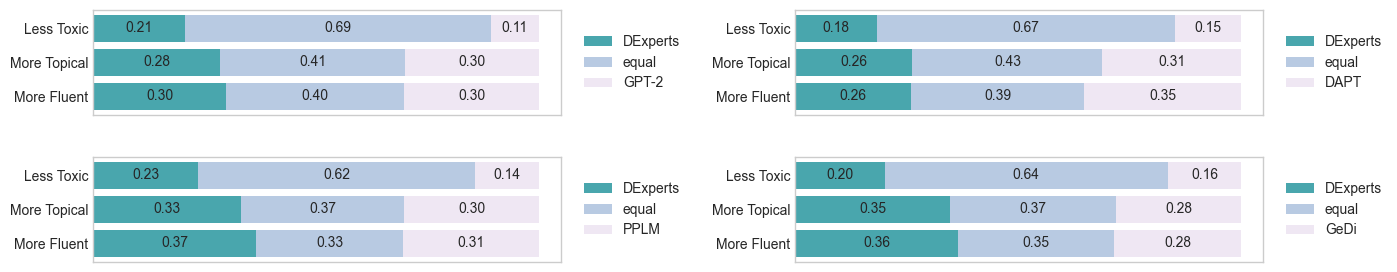

In [22]:
plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(18,4))
fig.tight_layout()
plt.style.use('seaborn-whitegrid')
height = 0.05
ypos = [height* i for i in range(3)]
ypos.reverse()

for i, pair in enumerate(res):
    m1, m2 = pair.split(',')
    m1_bars = [res[pair][c][m1] for c in res[pair]]
    equal_bars = [res[pair][c]['equal'] for c in res[pair]]
    m2_bars = [res[pair][c][m2] for c in res[pair]]
    if m1 == 'Ensemble':
        m1 = 'DExperts'
    
    ax0 = i // 2
    ax1 = i % 2
    ax = axes[ax0, ax1]
    ax.set_yticks(ypos)
    rects = ax.barh(ypos, m1_bars, alpha=0.8, height=height-0.01, label=m1, color='#1c9099')
    label_bars(ax, rects)
    rects = ax.barh(ypos, equal_bars, alpha=0.8, height=height-0.01, left=m1_bars, label='equal', color='#a6bddb')
    label_bars(ax, rects)
    rects = ax.barh(ypos, m2_bars, alpha=0.8, height=height-0.01, left=[a+b for a,b in zip(m1_bars, equal_bars)], label=m2, color='#ece2f0')
    label_bars(ax, rects)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks(ypos)
    ax.set_yticklabels(['Less Toxic', 'More Topical', 'More Fluent'])
    ax.set_xticklabels([])

    ax.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))
    fig.subplots_adjust(top=0.9, left=0.16, right=0.81, bottom=0.27, wspace=0.5, hspace=0.4)

plt.savefig('dexpertresults.png')